# <!-- TITLE --> - TITLE : CONSTRUCTION D'UN RESEAU DE NEURONE CONVOLUTIF -
<img  src="https://th.bing.com/th/id/R.0aaf9e85c30b4371246523d899ac485e?rik=w1qsqKXK6G7rpw&riu=http%3a%2f%2fwww.keil.com%2fpack%2fdoc%2fCMSIS_Dev%2fNN%2fhtml%2fCIFAR10_CNN.gif&ehk=%2fmLmJkB%2bQ%2fYXKrtUx7PwBTSMrqBS1OocIjU2v%2byUqSs%3d&risl=&pid=ImgRaw&r=0"></img>

#### <!-- AUTHOR --> - Author : __Dr. Amiehe-Essomba__ (c) 2023

## Description du projet : 
Le reseau que nous allons mettre en place ressemblera à cellui de l'image, ou nous avons une volume en entrée 
(une image) de dimension (largeur, hauteur, profondeur) ou
  - __largeur__ est la largeur de l'image 
  - __hauteur__ est la hauteur de l'image 
  - __profondeur__ est le nombre de canneaux de l'image (RBG) si ```profondeur = 3```

Ce volume (imaage) est traité de la la magnière suivante :
Nous avons une noyau de dimension (n, n, profondeur) appelé nouyau de convolution que nous allons appliqué  sur 
le volume d'entrée et obtenir un volume de sorti qui corespond à une image intermediaire nous pouvons ainsi
appliquer plusieurs filtres de convolutions pour fragementer de façon plus significative le volume d'entré.

Ceci voudrait tout simplement dire que  si nous avons une image de ```(32x32x3)```
```python
  - hauteur = 32
  - largeur = 32
  - profondeur = 3
```
avec un noyau de convolution de ```(3x3x3)```
nous obtiendrons une surface de dimension (26x26) en utilisant 32 filtres de convolution, l'image intermediaire 
obtenue aura pour dimension (32x32x32) avec un ```padding p = 1``` pou conserver le volume d'entré. Nous verrons par la suite \
comment utiliser le __padding__ et le __stride__ pour manipuler l'image d'entrée.

Sur l'image intermediare de dimension ```(32x32x32)``` nous appliquerons ensuite un autre filtre pour 
extraire les caractéristiques les pertinentes en appliquant un MaxPooling ou un AvgPooling ce qui 
à pour objectif de reduire non seulement la taille de l'image intermediare en gardant les caractéristiques
les plus importante tout en convervant la nature d'entrée.

Ceci voudrait dire que si nous avons un volume avant d'appliquer un filtre de pooling, après avoir appliquer ce dernier la sorti
sera un également un volume cependant les dimensions de l'image seront resuites 

  - Notre image intermediare à pour dimension ```(32x32x32)``` avec un Maxpooling ayant pour filtre ```(2x2x32)```
  nous obtiendrons une seconde image intermediare de dimension (16x16x10). nous verrons également comment fonction le __Pooling__.

Ce procedé peut etre repété plusieur fois comme suite

```python
(32x32x3)      (3x3x3)  32 filtres   (2x2x32)         (3x3x32)  (50 filtre)  (2x2x32)
[image] -----> (Noyau) ------------> (Pooling) ------>(Noyau) ------------> (Poling) ----> (8x8x32) 
                        (32x32)             (16x16x32)            (16x16) 
                          p=1                                       p=1
```         

Une fois le procédé d'extraction terminé nous povons applatire les données pour obtenir un vecteur colone avec pour dimension \
```Vec.dim() = (512, 1)``` qui sara utilisé pour  la predmière couche dense de neurone Full connected (FC)

```python

                    Cov1('RelU')                   Cov2('RelU',)                   (4x4x32)
(28x28x3)      (3x3x3) 32 filtres (2x2x32)    (3x3x32) (32 filtre)   (2x2x32)      Vector         (200)          (classes)
[image] -----> (Noyau) ---------> (Pooling)---->(Noyau) --------->  (Poling).....Flatten()--->FC1('ReLU')---->FC1('Softmax')
                        (32x32)                            (16x16) 
                          p=1                                p=1
```


Comme le demontre le schema ci-dessus nous avons deux couches couche de convolutions et deux couches full connected.
  - La première coche full conncted(FC1) utilise comme fonction d'activation __ReLU__ avec ``` 200 ``` neurones 
  - La première coche full conncted(FC1) utilise comme fonction d'activation __Sotfmax__ avec ``` n_classes ``` neurone \
    car il s'agit dans ce cas d'une classification multiple (chien, chat, oiseau, etc...)
  - Les deux couches de convolutions utilisent également le function __ReLU__ comme fonction d'activation cependant avec un nombre \
    de paramètres différents


## Objectives :
  - Nosu allons construire un reseau de neurone convolutif (CNN) pour le traitement d'image 

#


In [115]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 

In [116]:
def padding(X : np.ndarray, pad : int = 0):
    """
    Noté que X à pour dimension (m, H, L, Nc)
    M = nombres d'images
    H = Hauteur de l'image 
    L = Largeur de l'image 
    Nc = profondeur de l'image 

    Padding constiste à faire du rembourage autour du volume d'entré(image) comme ci-dessous 
    
        pad
       ----->                    
        +---+---+---+---+---+---+
        | 0 | 0 | 0 | 0 | 0 | 0 | 
        +---+---+---+---+---+---+  
        | 0 |               | 0 |
        +---+               +---+
        | 0 |  IMAGE HERE   | 0 |
        +---+               +---+
        | 0 |               | 0 |
        +---+---+---+---+---+---+
        | 0 | 0 | 0 | 0 | 0 | 0 | 
        +---+---+---+---+---+---+
                            <-----
                              pad

    pour cela nous allons utilser la fonction numpy.pad() et nous allons ajouter des zeros autour de l'image 
    avec l'attribut constant_values de numpy.pad()

    Chaque image de X faisant (H, L, Nc) dimension le padding ne s'applique que sur (H, L)
    avec comme valeur : pad avec un mode constant

    La matrix final X_pad aura pour dimension (m, H+2*pad, L+2*pad, Nc)

    """

    pad_width = (
        (0,0),
        (pad, pad),
        (pad, pad),
        (0, 0)
    )
    return np.pad(array = X, pad_width=pad_width ,constant_values=(0, 0), mode='constant')

In [117]:
def kernel_dim(kernel : tuple = (), X_shape : tuple =()):
    error  = None
    if len(kernel) == 2:
        if kernel[0] == kernel[1]: 
            if type(kernel[0]) == type(int()):
                if type(kernel[0]) == type(kernel[1]): pass
                else: error = "type( kernel[0] ) != type( kernel[1] )"
            else:"type( kernel[0] ) != type( int() )"
        else: error = "kernel[0] != kernel[1]"
    else: error = "kerne.size() != 2"
    
    error 

In [118]:
def Conv(X : np.ndarray, kernel_size : tuple = (), filters : int = 1, stride : int = 2, pad :int = 1):
    """ 
    pour faire une convolution, comme expliqué plus haut nous avons besoin d'un noyau de 
    convolution de dimension (n, n, Nc)

    ou Nc est la profondeur de la couche précédente 
    """
    # checking kernel size 
    error = kernel_dim(kernel=kernel_size)

    if error is None:
        # conversion du kernel en liste 
        kernel_size = list(kernel_size)
        
        # etape 1 : calcule la taille de l'image de sortie avec un paddind = pad et stride = stride
        n_H             = (X.shape[1] + 2 * pad - kernel_size[0])//stride + 1
        n_L             = (X.shape[2] + 2 * pad - kernel_size[1])//stride + 1 

        """ 
                Before
          +------------------+  
          |                  |  
          |                  |       after padding  and stride
          |   image here     |----------------------------------+  
          |                  |                                  |
          |                  |                                  |   
          |                  |                                  |
          +------------------+                                  |
                                                    +------------------------+
                                                    |  +------------------+  |
                                                    |  |                  |  |
                                                    |  |                  |  |  
                                                    |  |   image here     |  | 
                                                    |  |                  |  |
                                                    |  |                  |  |
                                                    |  |                  |  |
                                                    |  +------------------+  |
                                                    +------------------------+
                                                                After
        """
        # hyper paramètre 
        hp = {
            "pad"       : pad,
            "stride"    : stride
        }

        # étape 2 :  du padding 
        X_padding = padding(X=X, pad=pad)

        # dimension de X
        shape_X         = X_padding.shape 
    
        # noyau final
        kernel_size     = kernel_size + [shape_X[-1]]
        #ajout du filtre dans ma matrice de convolution 
        kernel          = np.random.randn(filters, kernel_size[0], kernel_size[1], kernel_size[-1] )
        kernel_shape    = kernel.shape
        
        # initialisation du biais
        bias = np.random.randn(1,1,1, filters)
        
        # X_CONV
        X_conv          = []

        if n_H > 1: 
            if n_L > 1:
                for i in range(shape_X[0]):
                    
                    # initialisation de la matrice de filtre
                    X_img = []
                    # boucle for en fonction du nombres de filtres appliqués
                    for j in  range(filters):
                        X_filters = []
                        # 1er verification s
                        # la taille du noyau est identique aux dimensions de l'image 
                        if kernel_shape[1] == shape_X[1]:
                            S   = X_padding[i] * kernel[j] + bias
                            SUM = S.sum().reshape((1,))[0] 
                            X_filters.append(SUM)
                        # la taille du noyau est inférieur à la taille de l'image 
                        elif kernel_shape[1] < shape_X[1]:
                            #size_H = shape_X[1] - kernel_shape[1] 
                            #size_L = shape_X[2] - kernel_shape[2]
                            pas_H  = kernel_shape[1]
                            pas_L  = kernel_shape[2]
                                                
                            # balayage du volume avec un pas de 1
                            for k in range(n_H):
                                for l in range(n_L):
                                    S   = X_padding[i][ k * stride : pas_H + k * stride, l * stride : pas_L + l * stride , :]
                                    S   = S * kernel[j] + bias[0, 0, 0, j]
                                    SUM = S.sum()
                                    X_filters.append(SUM)
                            
                        else: print('ERROR')

                        X_filters = np.array(X_filters).reshape((n_H, n_L))
                        X_img.append(X_filters)

                    X_conv.append( np.array(X_img).reshape(n_H, n_L, filters) )
                
                cache = (X, kernel, bias, hp )
                X_conv = np.array( X_conv)
            
                return X_conv , cache
            else: return f"Impossible d'appliquer le noyau de convolution {kernel_size}" , None
        else : return f"Impossible d'appliquer le noyau de convolution {kernel_size}" 
    
    else: return error , None


In [119]:
def Pooling(X : np.ndarray, mode : str = 'MaxPooling', pool_size : tuple = (2, 2), params : dict = {}):
    # dimension de X
    shape = X.shape 

    # taille finale du filtre du pooling 
    # le pooling prend un volume en entré et retourne un volume c'est-a-dire 
    # si notre image est de dimension (n,n, c) ----> pool_size(2,2) ----->(n//2, n//x, c)
    pool_size = list(pool_size) + [shape[-1]]
    # stride 
    stride = params['stride']
    # sample 
    sample = shape[0] 
    # channels
    n_c = shape[-1]

    # hauteur de l'image de sortie
    n_H = (shape[1] - pool_size[0])// stride + 1
    # largeur de l'image de sorties
    n_L = (shape[2] - pool_size[1])// stride + 1

    # initialisation de la matrice de pooling
    X_pool = np.zeros((sample, n_H, n_L, n_c))

    if n_H > 1:
        if n_L > 1:
            for i in range(sample):
                for c in range(n_c) :
                    for h in range(n_H):
                        for w in range(n_L):
                            x_pool = X[i][h * stride : h * stride + pool_size[0], w * stride : w * stride + pool_size[1], c]
                            if   mode =='MaxPooling': X_pool[i, h, w, c] = np.max(x_pool)
                            elif mode == 'AvgPooling' : X_pool[i, h, w, c] = np.mean(x_pool)
                            else : X_pool[i, h, w, c] = np.nan 

                        else: pass 
                    else: pass 
                else: pass 
            else: pass 
            params['pool_shape'] = pool_size
            cache = (X, params )
            return X_pool, cache
        else: return f"Impossible d'appliquer le {mode} avec un noyau {pool_size}" , None
    else: return f"Impossible d'appliquer le {mode} avec un noyau {pool_size}" , None


In [120]:
def mask_function(X : np.ndarray):
    """
    X.dim() = [filters, filters]
    """

    mask = X == X.max()
    
    return mask

In [121]:
def dist_value(dz, shape, mode : str = 'AvgPooling'):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    

    # (n_H, n_W) = None
    (n_H, n_W) = shape
    # Compute the value to distribute on the matrix 
    # average = None
    
    avg = dz / (n_H*n_W)
    
    # Create a matrix where every entry is the "average" value 
    X = np.zeros((n_H, n_W)) 
    X[:, :] = avg
  
    return X

In [122]:
def Conv_Backward(dZ : np.ndarray, cache : tuple = ()):

    """"
    dans cette section nous allons résoudre les equation de la rétropropagation (backward propagation)

    * dX = dX + sum( sum( kernel * dZ_{H, L}  ) )
    * dW = dW + sum( sum( X * dZ_{H, L} ) )
    * db = dbias + sum( sum( dZ_{H, L} ) )
    
    ces trois equations permettent de reésoudre la rétropropagation 
    
    """
    # données contenant les catéristique de l'image intermedaire, la forme du noyau, le bias et 
    # les hyper paramètres tels que le stride et le padding
    (X, kernel, bias, params) = cache
    # forme de l'image intermediare après la convolution
    X_shape         = X.shape 
    # forme du noyau filnal obtenu lors de la convolution sur le volume X
    kernel_shape    = kernel.shape
    # forme de l'image intermediare après convolution
    dZ_shape        = dZ.shape 
    # données du pad et du stride
    pad             = params['pad']
    stride          = params['stride']
    # initialisation de nouveaux paramètres pour le rétro propagation
    """ 
    dX = dX + sum_{h}[sum_{w} kernel[f, :, :, :] * dZ[m, h, w, filters]]
    db = db + dZ[m, h, w, filters]
    dW = dW + sum_{h}[sum_{w} x_slice * dZ[m, h, w, filters]]

    """
    # la function cout du gradient en fonction de la sortie de la couche de convolution
    dX              = np.zeros(X_shape)
    # dérivée du kernel
    dW              = np.zeros(kernel_shape)
    # derivée du bias
    dbias           = np.zeros((1,1,1,kernel_shape[-1]))
    # hauteur du noyau
    pas_H           = kernel_shape[1]
    # largeur du noyau
    pas_L           = kernel_shape[2]
    # dimension de l'image intermediare apres la Conv
    (m, n_H, n_L, filters) = dZ_shape 

    # padding sur le volue X avec une valeur constante et un pas = pad
    X_padding       = padding(X=X, pad=pad)
    # padding sur dX
    dX_padding      = padding(X=dX, pad=pad)

    for i in range(m):
        dx_padding = dX_padding[i]
        x_padding  = X_padding[i]
        for f in range(filters):
            for h in range(n_H):
                for w in range(n_L):
                    x_slice = x_padding[h *stride : h*stride+pas_H, w *stride : w*stride+pas_L, :]
                    dx_padding[h *stride : h*stride+pas_H, w *stride : w*stride+pas_L, :] += kernel[f, :, :, :] * dZ[i, h, w, f]
                    dW[f,:,:,:] += x_slice * dZ[i, h, w, f]
                    dbias[:,:,:,f] += dZ[i, h, w, f]
                else : pass 
            else: pass 
        else: pass 
        
        dX_padding[i, :, :, :] = dx_padding
    
    return dX_padding[:, pad:-pad, pad:-pad, :], dW, dbias

In [123]:
def Pooling_Backward(dZ : np.ndarray, cache : tuple = (), mode : str = "MaxPooling"):

    """"
    dans cette section nous allons résoudre les equation de la rétropropagation (backward propagation)

    * dX = dX + sum( sum( kernel * dZ_{H, L}  ) )
    * dW = dW + sum( sum( X * dZ_{H, L} ) )
    * db = dbias + sum( sum( dZ_{H, L} ) )
    
    ces trois equations permettent de reésoudre la rétropropagation 
    
    """
    # données contenant les catéristique de l'image intermedaire après le pooling
    # les hyper paramètres tels que le stride et le filtre
    (X, params) = cache
    # forme de l'image après le pooling
    X_shape         = X.shape 
    # forme de l'image intermediare après le pooling
    dZ_shape        = dZ.shape 
    # données stride et du filtre
    stride          = params['stride']
    kernel_shape    = params['pool_shape']
    # initialisation de nouveaux paramètres pour le rétro propagation
    
    dX              = np.zeros(X_shape)
    # hauteur du noyau
    pas_H           = kernel_shape[0]
    # largeur du noyau
    pas_L           = kernel_shape[1]
    # filter
    filter          = kernel_shape[-1]
    # dimension de l'image intermediare apres la Conv
    (m, n_H, n_L, filter) = dZ_shape 
    
    for i in range(m):
        x = X[i]
        for f in range(filter):
            for h in range(n_H):
                for w in range(n_L):
                    if mode == "Maxploing":
                        x_prev  = x[h * stride:h * stride + pas_H , w * stride : w * stride + pas_L]
                        mask    = mask_function(X=x_prev)
                        dX[i, h * stride:h * stride + pas_H , w * stride : w * stride + pas_H, f] += mask * dZ[i, h, w, f]
                    elif mode == 'AvgPooling':
                        dx      = dZ[i, h, w, f]
                        shape   = (filter, filter)            
                        dX[i, h * stride:h * stride + pas_H , w * stride : w * stride + pas_H, f] += dist_value(dx, shape)
                else : pass 
            else: pass 
        else: pass 
        
    assert( dX.shape == X.shape)
    
    return dX

In [124]:
np.random.seed(1)
X           = np.random.randn(4, 3, 3, 2)
X_padding   = padding(X, 3)

In [125]:
X_conv, cache_conv = Conv(X=X_padding, kernel_size=(4,4), filters=2, stride=2)

In [126]:

dA, dW, db = Conv_Backward(dZ=X_conv, cache=cache_conv)

In [127]:
params = {'stride' : 1}
X_pool, cache = Pooling(X_conv, params=params)

In [128]:
X_conv.shape, X_pool.shape

((4, 4, 4, 2), (4, 3, 3, 2))

In [129]:
dX = Pooling_Backward(dZ=X_pool, cache=cache, mode='AvgPooling')

Text(0.5, 1.0, 'Image with padding')

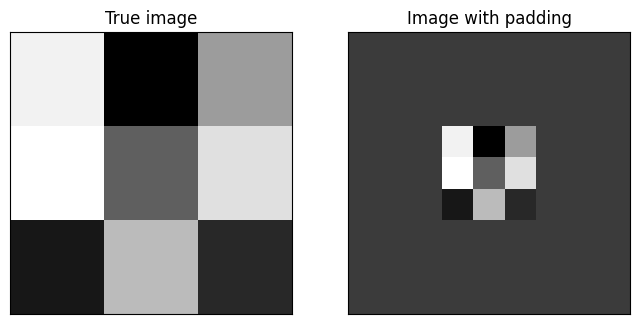

In [130]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax1, ax2  = axes.ravel()
ax1.imshow(X[0, :, :, 0], cmap="gray", interpolation='nearest')
ax2.imshow(X_padding[0, :, :, 0], cmap="gray", interpolation='nearest')

ax1.set_xticks(())
ax2.set_xticks(())
ax1.set_yticks(())
ax2.set_yticks(())

ax1.set_title('True image')
ax2.set_title('Image with padding')